# Using RomanMachine to fit a PRF model

This tutorial notebook shows how to use `RomanMachine` to build and save a PRF model from the 
simulated images.

We start with the basic imports...

In [2]:
import os
import sqlite3
import pandas as pd
import numpy as np
# import lightkurve as lk
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from astropy.io import fits

from roman_lcs import RomanMachine
from roman_lcs.utils import to_fits

We define a few global variables to be used in the notebook. 
You'll need to change the `PATH` to match where your simulated images are stored.

For this example, we will use simulated images from `RImTimSim` in the F146 band, field 3 and the SCA 2

In [3]:
# change PATH to you local directoy with the images
PATH = "/Users/jimartin/Work/ROMAN/TRExS/simulations/dryrun_01"
FILTER = "F146"
FIELD = 3
SCA = 2

In [5]:
ff = sorted(glob(f"{PATH}/simulated_image_data/rimtimsim_WFI_lvl02_{FILTER}_SCA{SCA:02}_field{FIELD:02}_rampfitted_exposureno_*_sim.fits"))
print(f"There are {len(ff)} frames available in {FILTER}")

There are 3298 frames available in F146


Because the FFI is 4088 x 4088 pixels and is too large to fit at once, memory limitations and inversion of large matrices are untractable,
we will work in smaller cutouts. 
To build the PRF model we will use 256 x 256 pixel cutouts in the center of the FFI. This tutorial uses one cutout as an example, but PRF models can be computed for multiple cutouts across the FFI. Because the current version of `RImTimSim` simulations does not change the PRF in time or across the SCA, we can compute a single average model for the entire FFI. 
Aditionally, we'll only use bright (F146 < 21) isolated stars to build the PRF model. Magnitude dependency for the ORF model will be implemented in future versions. 

Now we read the input catalog from where we'll use the source locations and a first guess of the star flux. We filter sources inside the cutout and brighter than `mag_limit`

In [6]:
cutout_size = 256
cutout_origin = (1792, 1792)
mag_limit = 21

with sqlite3.connect(f"{PATH}/metadata/TRExS_dryrun_01_MASTER_input_catalog_v1.1.db") as conn:
        query = (
            f"F146 <= {mag_limit} and "
            f"MEAN_XCOL >= {cutout_origin[0]} and MEAN_XCOL <= {cutout_origin[0] + cutout_size} and "
            f"MEAN_YCOL >= {cutout_origin[1]} and MEAN_YCOL <= {cutout_origin[1] + cutout_size}"
        )
        sources = pd.read_sql_query(
            f"SELECT * FROM Master_input_catalog WHERE {query}", conn
        ).reset_index(drop=True)

# we rename the table columns so RomanMachine can use them
sources = sources.rename(
        columns={
            "RA_DEG": "ra",
            "DEC_DEG": "dec",
            "MEAN_XCOL": "column",
            "MEAN_YCOL": "row",
            f"{FILTER}_flux": "flux",
            f"{FILTER}_flux_err": "flux_err",
        }
    )
sources

sicbro_id          ra        dec       column          row     F062  \
0           485  268.492709 -29.205453  1942.561096  1956.774163  21.3311   
1          1402  268.492968 -29.203003  1908.865620  2032.813727  22.8722   
2          1974  268.490785 -29.201827  1835.053702  2034.711511  21.4246   
3          2164  268.488798 -29.202259  1792.509250  1992.171988  23.3617   
4          2825  268.490064 -29.204647  1863.262328  1940.829653  22.4392   
...         ...         ...        ...          ...          ...      ...   
1845    4972506  268.490400 -29.209570  1952.399376  1800.841806  20.0674   
1846    4972710  268.491005 -29.206618  1919.117790  1896.877473  19.9720   
1847    4972847  268.490970 -29.202617  1852.631122  2014.215558  18.2691   
1848    4972850  268.489604 -29.204565  1850.443519  1936.324893  20.1870   
1849    4973098  268.491440 -29.202875  1868.586046  2013.675913  20.2442   

         F087     F106     F129     F158  ...  lowmassEB  lowRedNoise  \
0     20.1337  19.6439  19.1540  18.9670  ...          0            0   
1     21.5010  20.9300  20.3590  20.1942  ...          0            0   
2     20.5647  20.1970  19.8293  19.7029  ...          0            0   
3     21.9522  21.3550  20.7578  20.6040  ...          0            0   
4     21.2533  20.7924  20.3314  20.1195  ...          0            0   
...       ...      ...      ...      ...  ...        ...          ...   
1845  19.3571  19.0990  18.8409  18.6984  ...          0            0   
1846  19.1784  18.8989  18.6195  18.4194  ...          0            0   
1847  17.5345  17.2334  16.9322  16.7241  ...          0            0   
1848  19.4660  19.2523  19.0385  18.9303  ...          0            0   
1849  19.3076  18.9644  18.6212  18.3747  ...          0            0   

      hiRedNoise  variable     F087_flux  F087_flux_err          flux  \
0              0         0    916.150173      30.267973   2407.945583   
1              0         1    260.043898      16.125877    789.308297   
2              0         0    615.980080      24.818946   1252.237393   
3              1         1    171.619514      13.100363    546.873234   
4              0         0    326.683100      18.074377    826.202811   
...          ...       ...           ...            ...           ...   
1845           0         0   1873.297132      43.281603   3112.050732   
1846           0         0   2208.445408      46.994100   3952.270567   
1847           0         0  10037.987907     100.189759  18748.506089   
1848           0         0   1694.519879      41.164546   2545.227859   
1849           0         0   1960.679771      44.279564   4074.240562   

        flux_err     F213_flux  F213_flux_err  
0      49.070822   2204.381046      46.950836  
1      28.094631    736.218401      27.133345  
2      35.386966   1128.357365      33.591031  
3      23.385321    521.346747      22.833019  
4      28.743744    766.172691      27.679825  
...          ...           ...            ...  
1845   55.785757   2721.740202      52.170300  
1846   62.867087   3577.063651      59.808558  
1847  136.925184  16906.225918     130.023944  
1848   50.450251   2197.084034      46.873063  
1849   63.829778   3847.394042      62.027365  

[1850 rows x 26 columns]

## RomanMachine

We initialize a `RomanMachine` object with the images and the source catalog above.
Because the simulations were created with a static PSF, we can compute the PRF model from a single frame.

In [17]:
mac = RomanMachine.from_file(
    ff[:1], 
    sources=sources,
    sparse_dist_lim=2, 
    sources_flux_column="flux",
    cutout_size=cutout_size,
    cutout_origin=cutout_origin,
)
# we specify flux limit to consider contamination
# this helps get more datapoints to build the model
# in reality we should push this to lower values, but 
# that increases the chances to get an unsolvable
# system of equations
mac.contaminant_flux_limit = 10 ** ((27.648 - 21)/2.5)
mac

Creating delta arrays: 100%|████████████████████████████████████████████████████████| 1850/1850 [00:01<00:00, 1364.50it/s]


RomanMachine (N sources, N times, N pixels): (1850, 1, 65536)

We can inspect the frame we loaded and the sources in the catalog

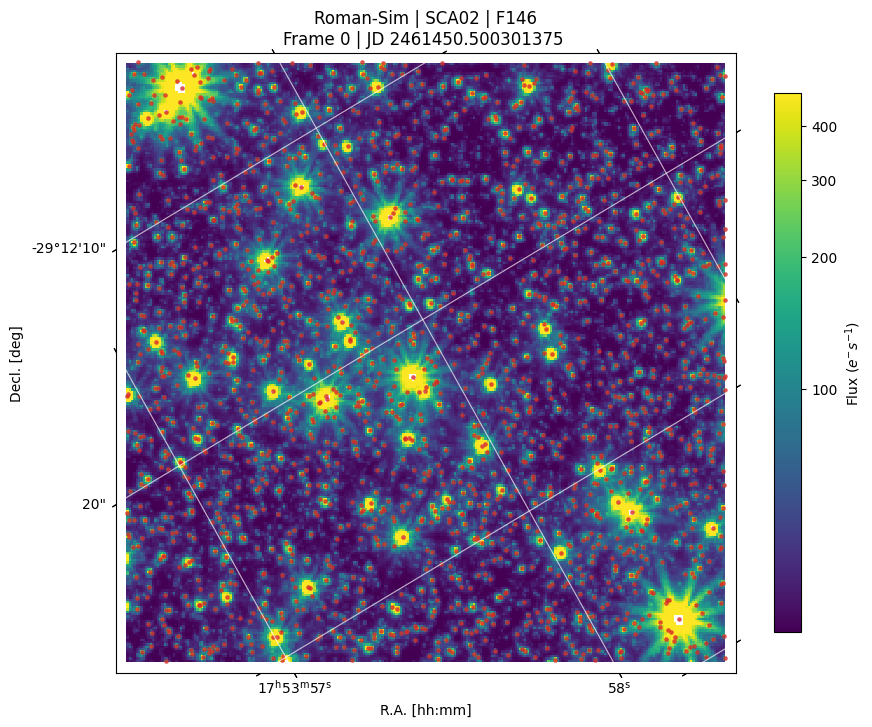

In [18]:
mac.plot_image(sources=True, frame_index=0);

We compute a pixe lmask for every source. The figures show the flux of each pixel and its distance to the postion of their source.
We fit a 1st-degree polynomial to the normalized pixel flux (in log space) and define the radius of a source when its flux goes near the background level (`source_flux_limit`).

Creating delta arrays: 100%|████████████████████████████████████████████████████████| 1850/1850 [00:01<00:00, 1385.00it/s]
/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


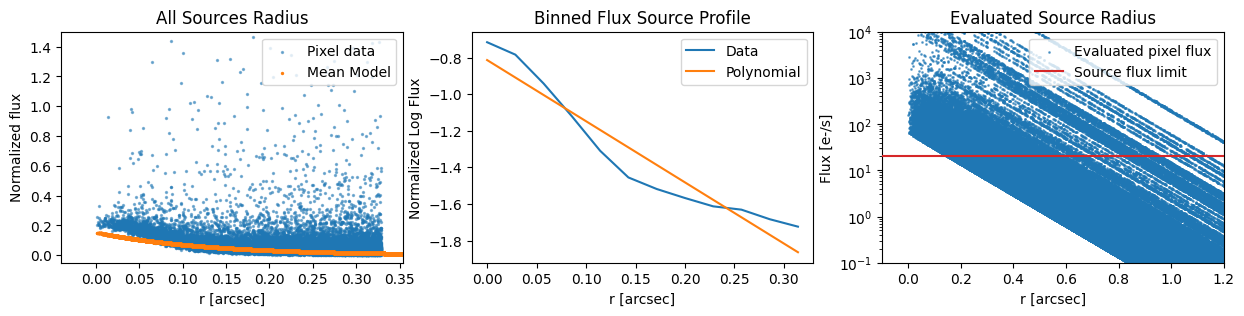

In [19]:
mac._get_source_mask(source_flux_limit=20, plot=True, reference_frame=0, iterations=1);

We can visualize a sample of sources and their source mask

In [20]:
# we select a fixed random set of bright sources 
examples = np.random.choice(mac.sources.query("F146 < 19").index.values, size=7*7)
examples

array([ 253,   92, 1745,   54, 1716, 1595, 1748, 1831, 1369,   69, 1748,
         35,  329, 1716, 1677, 1788,  253, 1684, 1696, 1662, 1630, 1804,
       1321,  490, 1834, 1764, 1790, 1846, 1716, 1589,  106,  286,  117,
       1819,  215,  108, 1766, 1686, 1838, 1625,    9,   59, 1725, 1694,
       1811, 1790, 1829,  154,   61])

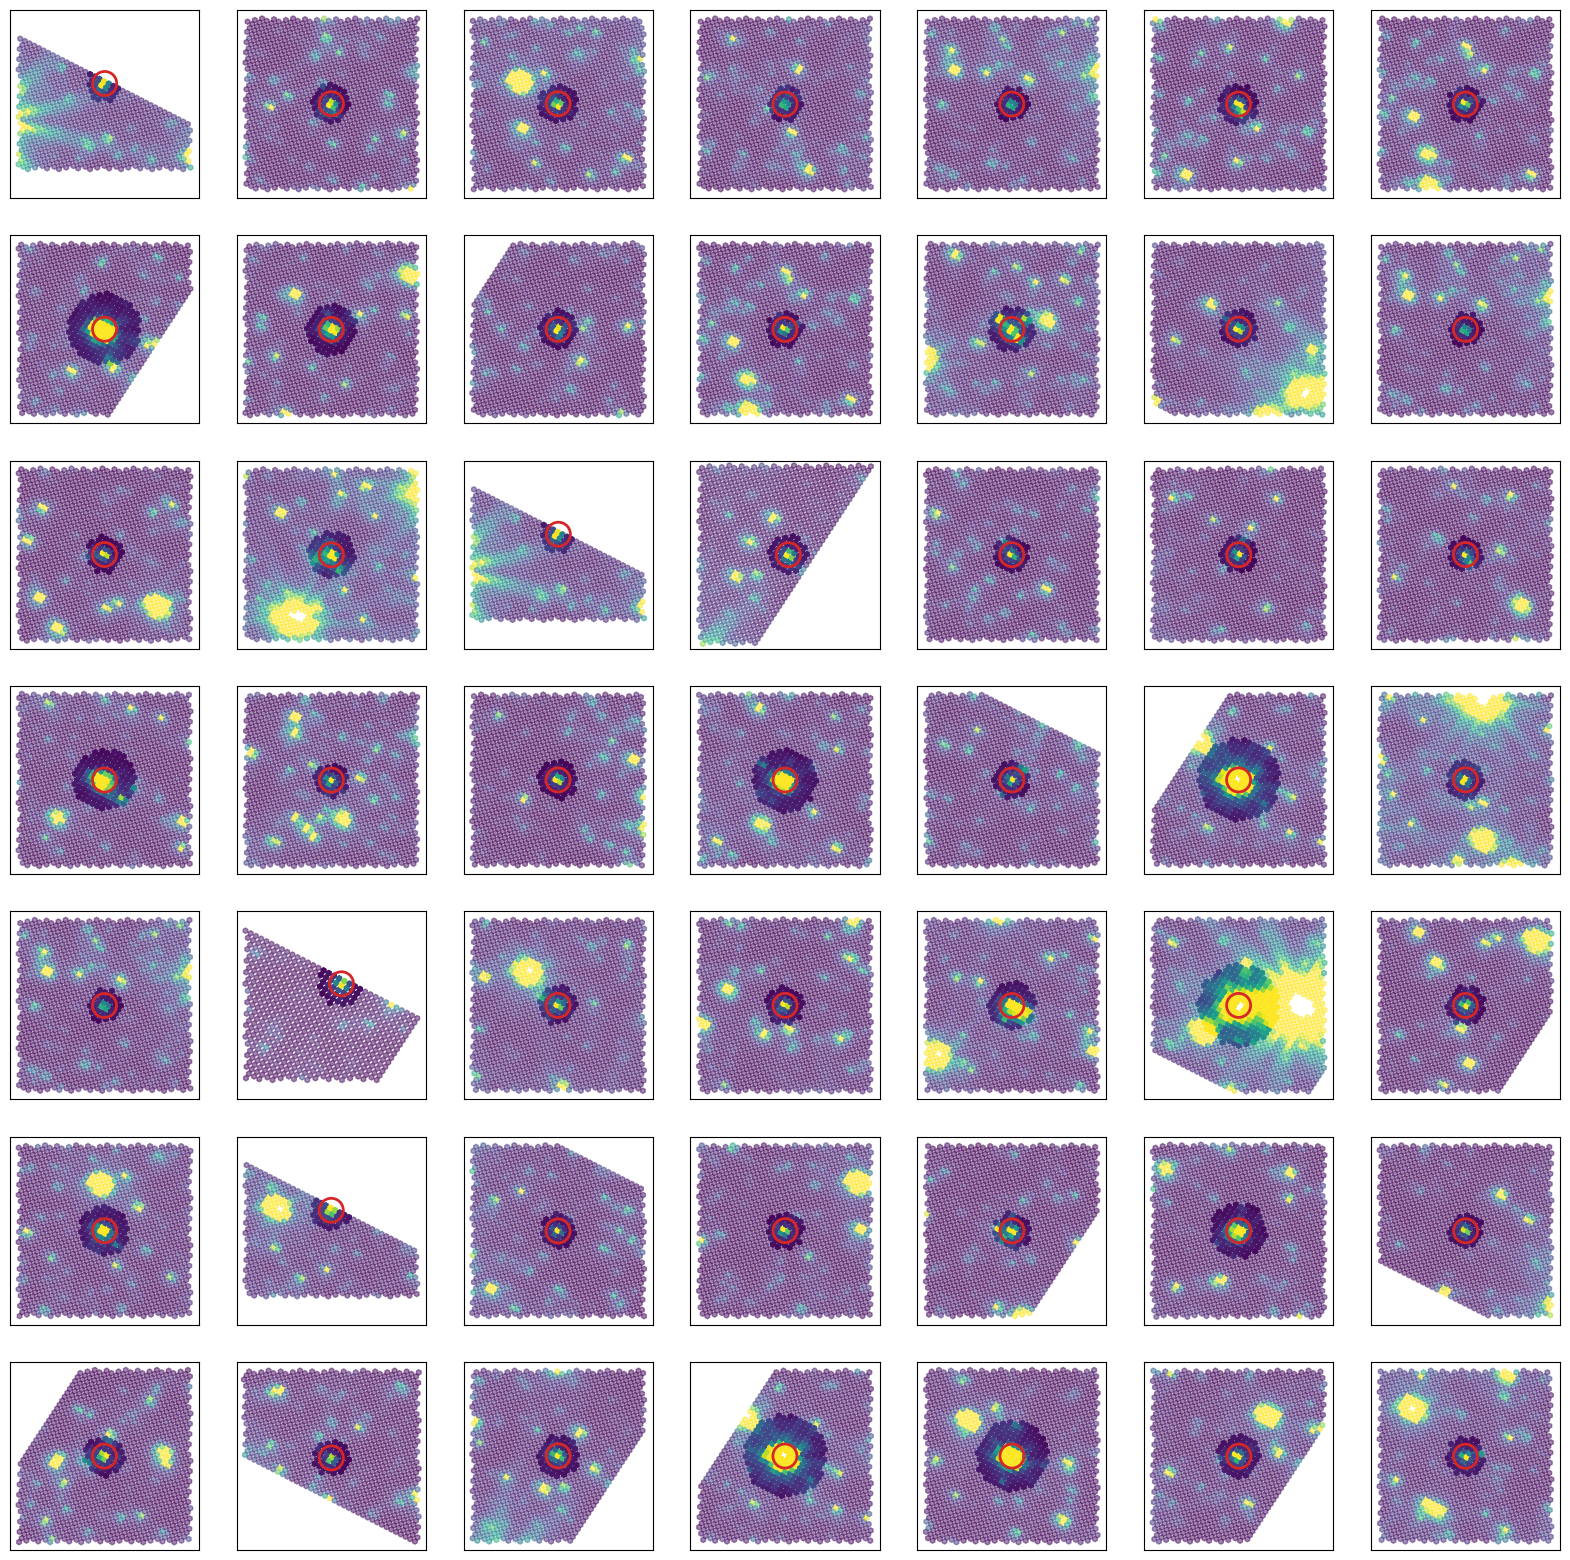

In [21]:
# we plot the source mask

flux_masked = mac.r.astype(bool).multiply(mac.flux[0]).tocsr()
source_mask_dx = mac.source_mask.multiply(mac.dra).tocsr()
source_mask_dy = mac.source_mask.multiply(mac.ddec).tocsr()
source_mask_flux = mac.source_mask.multiply(mac.flux[0]).tocsr()

fig, ax = plt.subplots(7, 7, figsize=(20,20))

for i, k in enumerate(examples):
    ax.ravel()[i].scatter(mac.dra[k].data*3600, 
                          mac.ddec[k].data*3600, 
                          s=15, marker="h", 
                          c=flux_masked[k].data, 
                          alpha=0.5,
                          vmin=10, vmax=500)
    ax.ravel()[i].scatter(source_mask_dx[k].data*3600, 
                          source_mask_dy[k].data*3600, 
                          s=15, marker="h", 
                          c=source_mask_flux[k].data, 
                          alpha=1,
                          vmin=10, vmax=500)
    ax.ravel()[i].scatter(0, 0, s=300, edgecolor="tab:red", marker="o", facecolor="none", lw=2)
    ax.ravel()[i].axis('equal')
    ax.ravel()[i].set_xticks([])
    ax.ravel()[i].set_yticks([])
plt.show()

`RomanMachine` computes a `source_mask`, which as the shape of `[nsources, npixels]`, with pixels that belong to a source. And also an `uncontaminated_source_mask`, with the same shape, but only with pixels that have a contribution from one source (down to `mac.contaminant_flux_limit`)

In [22]:
mac.source_mask, mac.uncontaminated_source_mask

(<Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 41514 stored elements and shape (1850, 65536)>,
 <Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 22795 stored elements and shape (1850, 65536)>)

We mask out saturated pixels and pixels near bright sources (F146 < 13) that are outside the linear response of the detector.

In [70]:
mac._mask_pixels(magnitude_bright_limit=13)

We can visualize the source mask and uncontaminated pixel mask to see if we have enough data points to build the PRF model

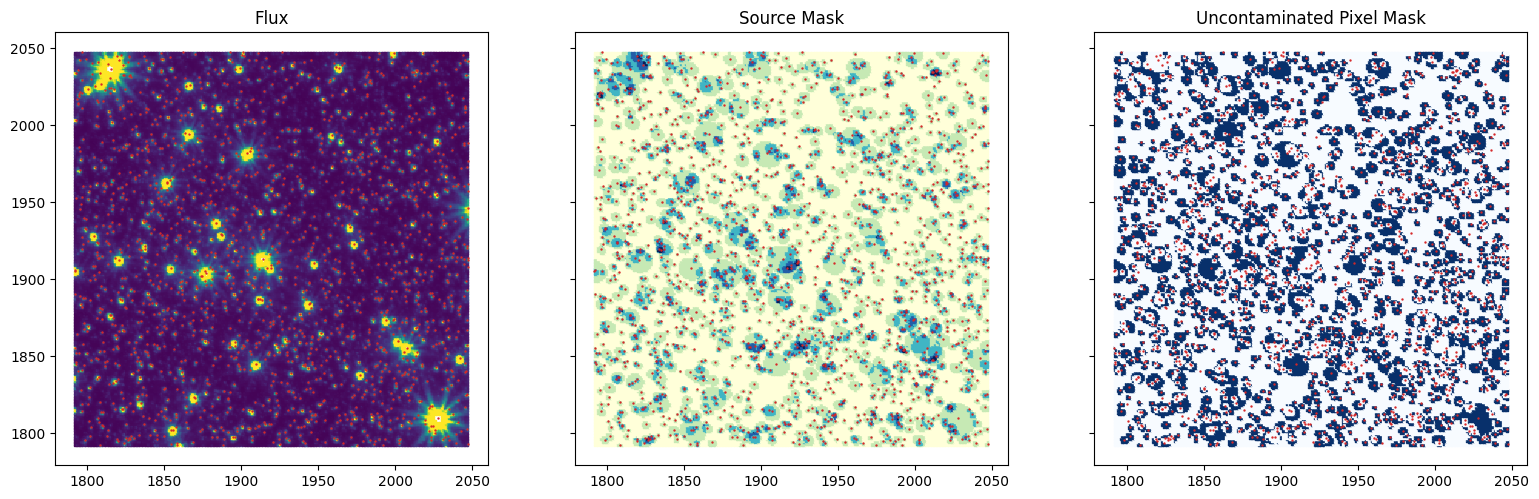

In [24]:
# mac._update_source_mask(frame_index=mac.ref_frame)
ROW, COL = mac.pixel_coordinates(mac.ref_frame)

fig, ax = plt.subplots(1, 3, figsize=(19, 9), sharex=True, sharey=True)

ax[0].set_title("Flux")
ax[0].scatter(
    mac.column,
    mac.row,
    c=mac.flux[mac.ref_frame], 
    vmin=10, 
    vmax=500,
    s=1,
    marker="s",
)
ax[0].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[1].set_title("Source Mask")
ax[1].scatter(
    mac.column,
    mac.row,
    c=np.array(mac.source_mask.sum(axis=0)[0]), 
    vmin=0, 
    vmax=4,
    alpha=1,
    cmap="YlGnBu",
    s=1,
    marker="s",
)
ax[1].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[2].set_title("Uncontaminated Pixel Mask")
ax[2].scatter(
    mac.column,
    mac.row,
    c=np.array(mac.uncontaminated_source_mask.sum(axis=0)[0]), 
    vmin=0, 
    vmax=1,
    alpha=1,
    cmap="Blues",
    s=1,
    marker="s",
)
ax[2].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[0].set_aspect("equal", adjustable="box")
ax[1].set_aspect("equal", adjustable="box")
ax[2].set_aspect("equal", adjustable="box")

plt.show()

Now we can build a PRF model from the data. We define a few model parameters like the minimun `rmin` and maximum `rmax` radius to fit the model in polar coordinates (these are related to the pixel scale), the radius at which the model start to be dependent on the polar angle (`cut_r`), and the number of knots for the radius and angle spline components. 
We also control where the PSF meets the background level with `flux_cut_off` parameter.

Creating delta arrays: 100%|████████████████████████████████████████████████████████| 1850/1850 [00:01<00:00, 1168.56it/s]


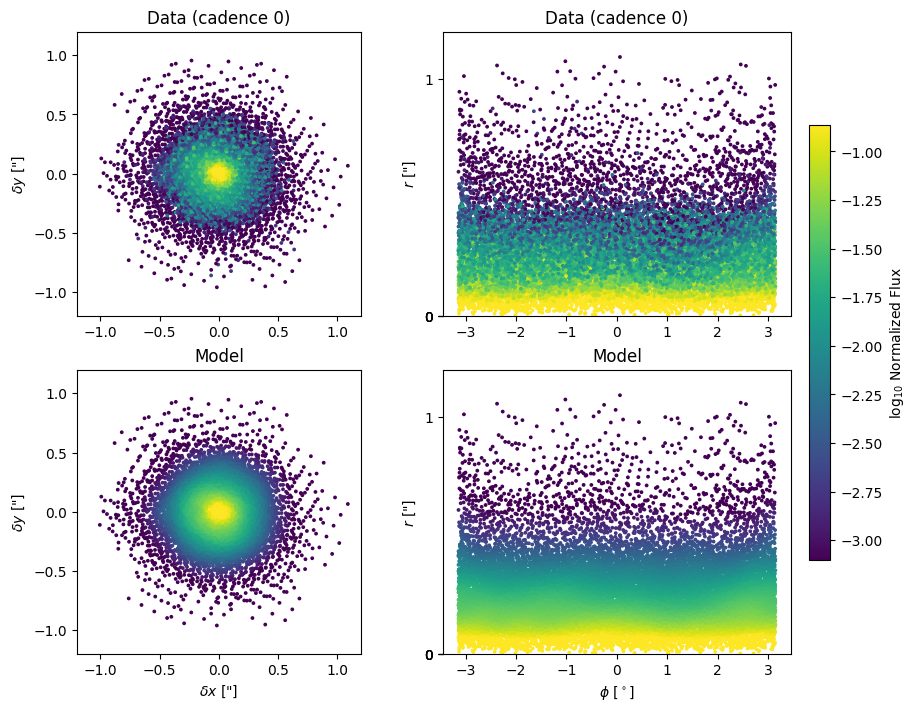

In [28]:
mac.rmin = 0.02
mac.rmax = 0.8
mac.cut_r = 0.2
mac.n_r_knots = 9
mac.n_phi_knots = 15
# we are fitting one single frame
psf_tdx = 0

mac.build_shape_model(
    plot=True,
    flux_cut_off=0.05,
    frame_index=psf_tdx,
    bin_data=False,
)
plt.show()

The top rows shows the data, each point is a pixel relative location to its source and the color is the normalized flux value.
The bottom row is the model we fit.
Both are show in cartesian (left) and polar (right) coordinates.

We can save the PRF model we built:

In [29]:
mac.meta

{'MISSION': 'Roman-Sim',
 'TELESCOP': 'Roman',
 'SOFTWARE': 'rimtimsim_v2.0',
 'RADESYS': 'FK5',
 'EQUINOX': 2000.0,
 'FILTER': 'F146',
 'FIELD': 1,
 'DETECTOR': 'SCA02',
 'EXPOSURE': 54.72,
 'READMODE': 'ramp'}

In [30]:
output = f"./data/roman_WFI_{mac.meta['READMODE']}_field{mac.meta['FIELD']:02}_SCA{mac.meta['DETECTOR']}_{mac.meta['FILTER']}_shape_model_cad{psf_tdx}.fits"
mac.save_shape_model(output=output)

We can see whats in the outputfile:

In [34]:
prf_model = fits.open(output)

The FITS file has relevant keywords to build the components of a design matrix using any pixel row and column grid, as well as metadata that refers to the field, detector, filter, etc.  

In [37]:
prf_model[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =                  168 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'psf_w   '                                                            
TFORM1  = 'D       '                                                            
OBJECT  = 'PRF shape'          / PRF shape parameters                           
DATATYPE= 'SimImage'           / Type of data used to fit shape model           
ORIGIN  = 'PSFmachine.RomanM

The data store are the weights that the design matrix is dotted to obtain the unscaled image model.

In [43]:
prf_model[1].data

FITS_rec([( -8.18351591,), ( -8.16472253,), ( -8.25041803,),
          ( -8.19768953,), ( -8.26348684,), ( -8.1852218 ,),
          ( -8.25202381,), ( -8.2851182 ,), ( -8.24093317,),
          ( -8.21222795,), ( -8.1556195 ,), ( -8.21983488,),
          ( -8.34435727,), ( -8.21884403,), ( -8.29076796,),
          ( -8.34188757,), ( -8.49028343,), ( -8.39246065,),
          ( -8.34415515,), ( -8.36689517,), ( -8.28743864,),
          ( -8.46395483,), ( -8.22347449,), ( -8.40693374,),
          ( -8.44619909,), ( -8.44249854,), ( -8.40451538,),
          ( -8.23049013,), ( -8.36279851,), ( -8.40147168,),
          ( -8.92851619,), ( -8.67896141,), ( -8.88578739,),
          ( -8.76083636,), ( -8.68178482,), ( -8.63539555,),
          ( -8.66354304,), ( -8.76637415,), ( -8.85045828,),
          ( -8.72558863,), ( -8.74650033,), ( -8.74768985,),
          ( -8.78028626,), ( -8.69582689,), ( -8.70273552,),
          ( -8.94726774,), ( -9.02424406,), ( -8.9662159 ,),
          ( -9.0220292 ,

We could use this PRF model to fit the photometry in this frame, but due to the large number of sources, the design matrix becomes singular, and least square fitting won't work. To solve this, we will have to load a smaller cutout (e.g. 32 x 32 pixels), to simplify the problem, and load the precomputed PRF model for evaluation. 

In [44]:
# this shows that fitting the model leads to a singular matrix and nan values in the resulting photometry.
mac.quiet = True
mac.fit_model()
# mac.ws has the flux values for each source, which in this case are all nan
print(np.nansum(mac.ws))

Fitting 1850 Sources (w. VA):   0%|                                                                 | 0/1 [00:00<?, ?it/s]

Fitting 1850 Sources (w. VA): 100%|█████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.50s/it]

0.0


# Evaluate Model on substamp with full catalog

We will use the PRF model we built above, to fit the photometry of sources in a smaller cutout including fainter sources `<23`.

In [47]:
cutout_size = 32
# cutout_origin = (0, 0)
mag_limit = 23

with sqlite3.connect(f"{PATH}/metadata/TRExS_dryrun_01_MASTER_input_catalog_v1.1.db") as conn:
        query = (
            f"F146 <= {mag_limit} and "
            f"MEAN_XCOL >= {cutout_origin[0]} and MEAN_XCOL <= {cutout_origin[0] + cutout_size} and "
            f"MEAN_YCOL >= {cutout_origin[1]} and MEAN_YCOL <= {cutout_origin[1] + cutout_size}"
        )
        sources = pd.read_sql_query(
            f"SELECT * FROM Master_input_catalog WHERE {query}", conn
        ).reset_index(drop=True)
sources = sources.rename(
        columns={
            "RA_DEG": "ra",
            "DEC_DEG": "dec",
            "MEAN_XCOL": "column",
            "MEAN_YCOL": "row",
            f"{FILTER}_flux": "flux",
            f"{FILTER}_flux_err": "flux_err",
        }
    )
sources

sicbro_id          ra        dec       column          row     F062  \
0       33553  268.485929 -29.207035  1799.139504  1808.449367  23.9476   
1       60148  268.486535 -29.207554  1822.781927  1802.230763  25.0878   
2       79297  268.486118 -29.206944  1802.380962  1813.954593  22.9040   
3      131006  268.485796 -29.207179  1798.183302  1802.196089  20.6234   
4      151514  268.485901 -29.207441  1805.100253  1796.057634  25.6784   
..        ...         ...        ...          ...          ...      ...   
93    4870735  268.485666 -29.207232  1795.785224  1798.684486  20.4237   
94    4891281  268.486388 -29.207209  1813.477099  1810.191886  20.1710   
95    4894635  268.486185 -29.207570  1814.307586  1796.532580  20.0717   
96    4925979  268.486595 -29.207039  1815.856517  1818.311086  20.3846   
97    4965185  268.486682 -29.206912  1815.935169  1823.369264  18.7203   

       F087     F106     F129     F158  ...  lowmassEB  lowRedNoise  \
0   22.5360  21.9538  21.3715  21.0826  ...          0            0   
1   23.5991  23.0192  22.4394  22.1785  ...          0            0   
2   21.8138  21.3810  20.9482  20.6574  ...          0            0   
3   20.0026  19.8368  19.6710  19.6022  ...          0            0   
4   24.1580  23.5124  22.8667  22.5521  ...          0            0   
..      ...      ...      ...      ...  ...        ...          ...   
93  19.8090  19.6462  19.4834  19.4370  ...          0            0   
94  19.5331  19.3819  19.2307  19.2173  ...          0            0   
95  19.4442  19.2954  19.1467  19.1386  ...          0            0   
96  19.7706  19.6190  19.4674  19.4511  ...          0            0   
97  17.8748  17.5223  17.1698  16.9455  ...          0            0   

    hiRedNoise  variable    F087_flux  F087_flux_err          flux  \
0            0         0   100.241295      10.012057    334.200171   
1            0         0    37.653614       6.136254    123.221550   
2            0         0   194.951539      13.962505    490.463472   
3            1         1  1033.728924      32.151655   1384.862541   
4            0         0    22.503324       4.743767     85.500109   
..         ...       ...          ...            ...           ...   
93           0         0  1235.511147      35.149839   1625.274300   
94           0         0  1592.966593      39.911986   2013.940651   
95           0         0  1728.887237      41.579890   2167.937053   
96           0         0  1279.990270      35.776952   1621.685629   
97           0         0  7337.137672      85.657094  15266.049567   

      flux_err     F213_flux  F213_flux_err  
0    18.281143    332.327797      18.229860  
1    11.100520    121.889605      11.040363  
2    22.146410    473.899956      21.769243  
3    37.213741   1158.154951      34.031676  
4     9.246627     85.728785       9.258984  
..         ...           ...            ...  
93   40.314691   1346.252951      36.691320  
94   44.876950   1647.732349      40.592270  
95   46.561111   1764.601598      42.007161  
96   40.270158   1326.559299      36.421962  
97  123.555856  14098.297416     118.736251  

[98 rows x 26 columns]

This 32 x 32 pixels cutout has 98 sources brighter than 23rd magnitude

We initialize `RomanMachine` with the input catalog and with all the frames we want to fit. In this example, only half of the season is available. This will take about half a minute, depending on how fast the FITS files are read, how big is the cutout, and how many frames are loaded.

In [48]:
mac = RomanMachine.from_file(
    ff, 
    sources=sources,
    sparse_dist_lim=2, 
    sources_flux_column="flux",
    cutout_size=cutout_size,
    cutout_origin=cutout_origin,
)
# we again define a contamination flux limit
mac.contaminant_flux_limit = 10 ** ((27.648 - 21)/2.5)
mac

100%|████████████████████████████████████████████████████████████████████████████████| 3298/3298 [00:23<00:00, 142.46it/s]


RomanMachine (N sources, N times, N pixels): (98, 3298, 1024)

We inspect a frame

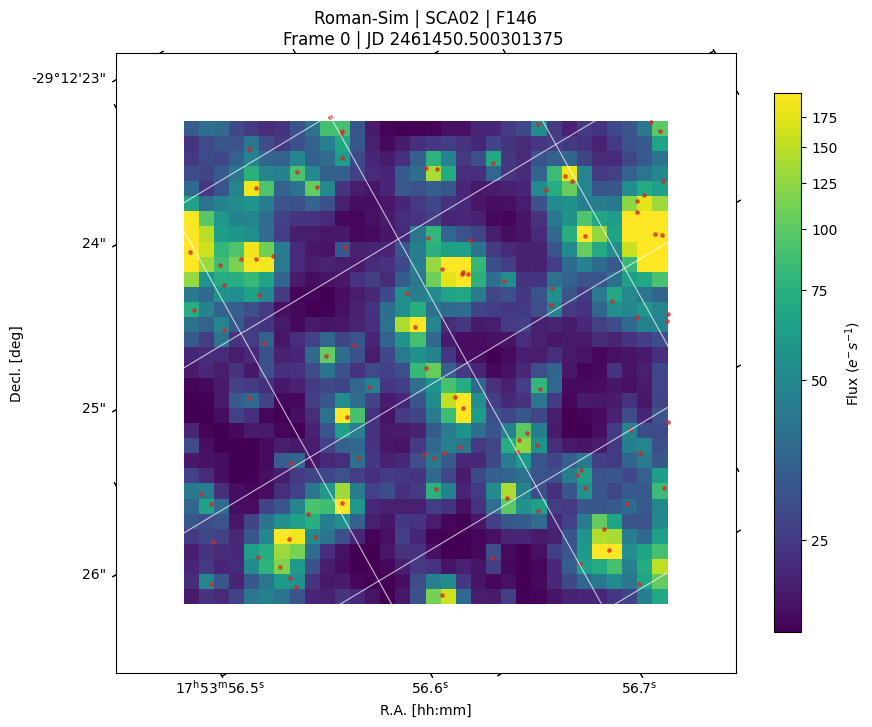

In [49]:
mac.plot_image(sources=True);

We load the PRF model weights and create the mean models to be used for evaluation

./data/roman_WFI_ramp_field01_SCASCA02_F146_shape_model_cad0.fits


/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


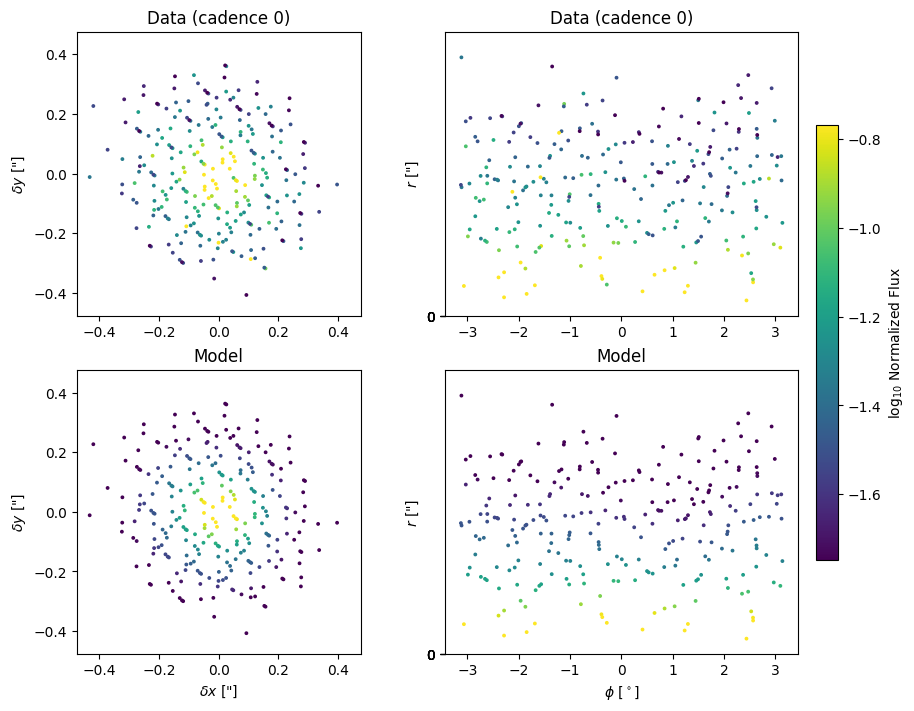

In [54]:
print(output)

mac.load_shape_model(output, flux_cut_off=0.1, plot=True, source_flux_limit=50);

The figure is the same as above, the pixel data (top) and the model (bottom). But this time, it's sparse due to less number of sources. 

In [38]:
from roman_lcs.utils import solve_linear_model
import tensorflow as tf

We fit the model to get the photometry. This could take from 1 to 10 min depending on the number of frames and computing resources. 

In [55]:
mac.fit_model()

Fitting 98 Sources (w. VA): 100%|█████████████████████████████████████████████████████| 3298/3298 [05:30<00:00,  9.97it/s]


In [58]:
# these variables have the flux and flux errors for every source [column] and frame [row]
mac.ws.shape, mac.werrs.shape

((3298, 98), (3298, 98))

We set the problem as a system of linear equations like `Ax = y` with `A` a square matrix the is built from the PRF model evaluated in the pixel grid of all sources to get a mean model o each source in the scene, `y` the pixel values in the image, and solving for `x`. Negative solutions for `x` are matematically allowed, within the range of the priors we set (the catalog flux values). 
We could improve this by narrowing the priors for sources with negative fluxes, `mac.fit_model()` has arguments that controls the mean and variance of the priors.

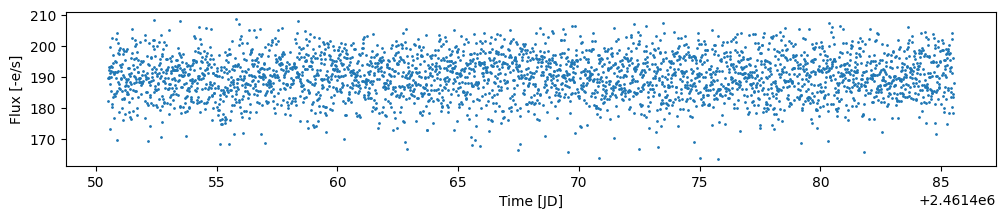

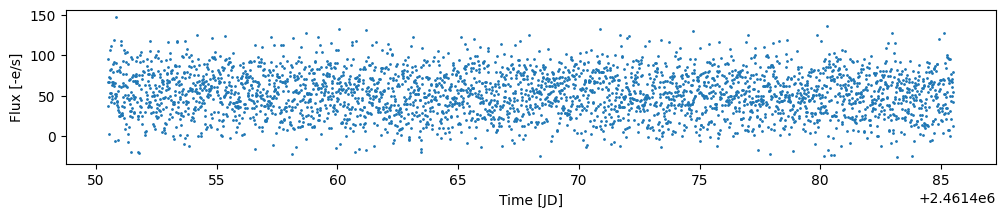

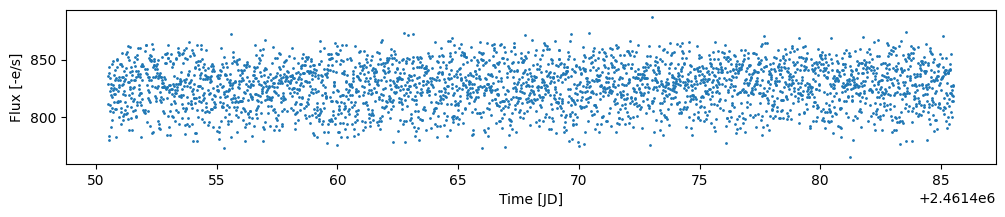

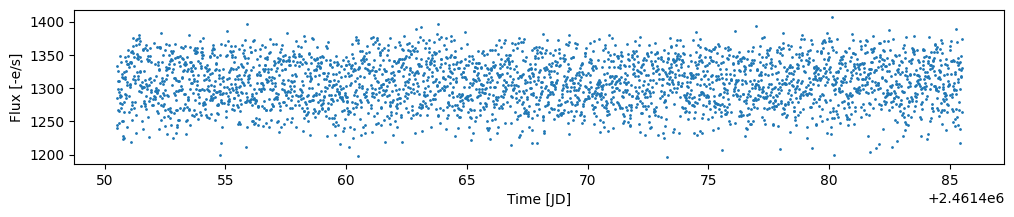

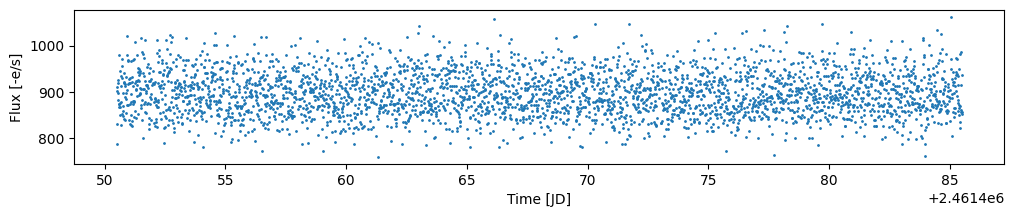

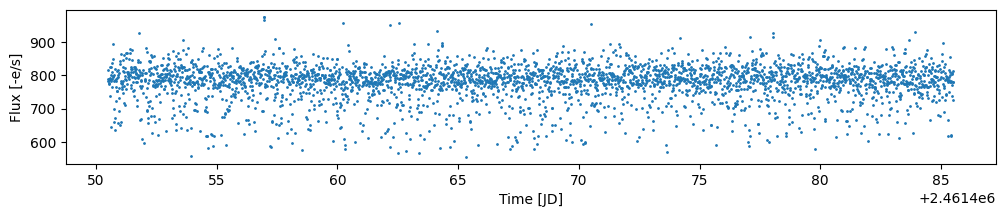

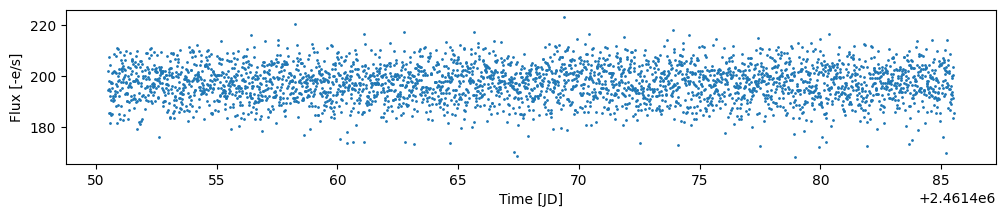

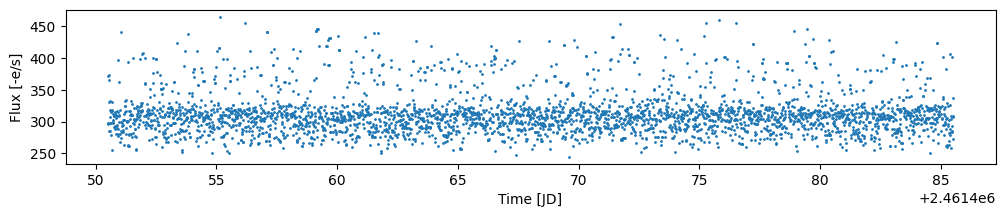

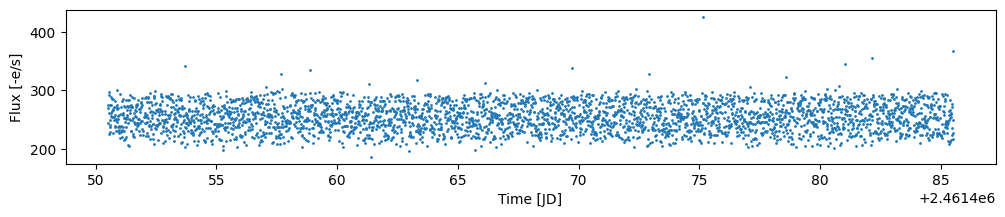

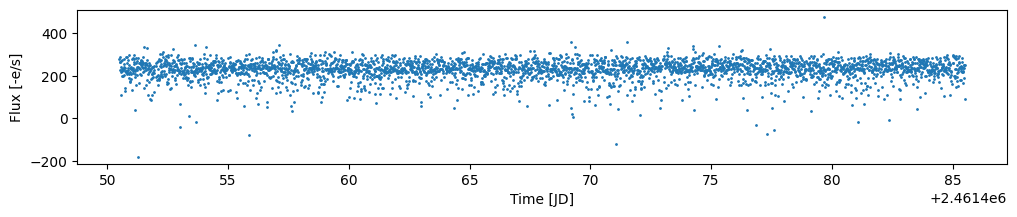

In [64]:
for k in mac.sources.sample(10, replace=False).index.values:
    plt.figure(figsize=(12,2))
    plt.scatter(mac.time, mac.ws[:, k], s=1)
    plt.xlabel("Time [JD]")
    plt.ylabel("Flux [-e/s]")
    plt.show()

Now we can save the light curves to FITS files:

In [66]:
# get PSF metrics
mac.get_psf_metrics(npoints_per_pixel=0)
psffrac = mac.source_psf_fraction / np.percentile(mac.source_psf_fraction, 75)
psffrac[psffrac>=1] = 1

In [69]:
for k in tqdm(range(mac.nsources), total=mac.nsources, desc="Saving FITS"):
    metadata = mac.meta.copy()
    metadata["INSTRUME"] = "WFI"
    metadata["SICBROID"] = mac.sources["sicbro_id"].iloc[k]
    metadata["RADESYS"] = "ICRS"
    metadata["RA_OBJ"] = mac.sources["ra"].iloc[k]
    metadata["DEC_OBJ"] = mac.sources["dec"].iloc[k]
    metadata[f"{FILTER}MAG"] = mac.sources[FILTER].iloc[k]
    metadata[f"{FILTER}FLX"] = np.round(mac.sources["flux"].iloc[k], decimals=3)
    metadata["PSFFRAC"] = np.round(mac.source_psf_fraction[k], decimals=3)

    # replace nans and negatives with 0
    quality = np.zeros(mac.nt, dtype=int)
    cadenceno = np.arange(mac.nt, dtype=int)
    flux = mac.ws[:, k]
    flux_err = mac.werrs[:, k]

    quality[~np.isfinite(mac.ws[:, k])] += 1

    neg_mask = np.isfinite(flux) & (flux < 0)
    quality[neg_mask] += 2
    
    pos_mask = np.isfinite(flux) & (flux >= 0)
    flux[~pos_mask] = np.nan
    flux_err[~pos_mask] = np.nan

    data = {
        "time": mac.time,
        "flux": flux,
        "flux_err": flux_err,
        "cadenceno" : cadenceno,
        "quality": quality,
    }
    fid = f"{metadata['SICBROID']:08}"
    fname = f"./data/lcs/roman_wfi_{fid}_{metadata['FILTER']}_dryrun01_lc.fits"
    to_fits(data, path=fname, overwrite=True, **metadata)

Saving FITS: 100%|███████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 103.75it/s]
